In [1]:
# -*- coding: utf-8 -*-
"""
@Author: Can Aytöre
"""

'\n@Author: Can Aytöre\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
class P:                    # simulation parameters
    lambd = 1               # rate parameter
    mu = 2                  # service rate
    sim_time = 200          # maximum simulation time per run
    sim_run = 10            # total simulation runs
    

In [4]:
class MM1:
    def __init__(self): 
        self.clock = 0.0                      # sim clock
        
        self.num_arrivals = 0                 # total number of arrivals
        self.num_departures = 0               # total number of departures (served by server)
        self.num_in_queue = 0                 # current number in queue
        self.num_stuck_in_queue = 0           # customers who had to wait in queue
        self.num_in_system = 0                # current number in system

        self.t_arrival = 0                    # time of next arrival  
        self.interarrival_list = []           # individual interarrivals (list)
        self.t_arrival_list = [0]             # time of whole arrivals (list)
        
        self.t_departure = float('inf')       # departure time from server
        self.service_list = []                # individual service times (list)
        self.t_departure_list = []            # time of whole departures (list)
        self.dep_sum = 0                      # sum of service times by server (to be able to monitor server utilization)
        self.t_service_list = []              # service start times at server (list)
        self.server_status = 0                # current state of server (binary - 0:available 1:busy)
        
        self.total_wait_time = 0.0            # total wait time
        self.wait_time_list = []              # waiting times  
        
       
    def schedule(self):                                                       # timing routine
        t_next_event = min(self.t_arrival, self.t_departure)                  # determine time of next event
        
        self.wait_time = self.num_in_queue * (t_next_event-self.clock)
        self.wait_time_list.append(self.wait_time)
        self.total_wait_time += self.wait_time
        
        self.clock = t_next_event
                
        if self.t_arrival < self.t_departure:
            self.arrival()
        else:
            self.departure()
            
        
    def arrival(self):              
        self.num_arrivals += 1
        self.num_in_system += 1
        
        # schedule next departure or arrival depending on state of server
        if self.num_in_queue == 0:
            
            if self.server_status == 1:       # when server is busy
                self.num_in_queue += 1
                self.num_stuck_in_queue += 1
                self.interarrival = self.generate_interarrival() #ADDED
                self.interarrival_list.append(self.interarrival) #ADDED
                self.t_arrival = self.clock + self.interarrival #CHANGED
                self.t_arrival_list.append(self.t_arrival) #ADDED
                
            else:                             # when server is available
                self.server_status = 1
                self.t_service_list.append(self.clock) #ADDED - service at server
                self.dep = self.generate_service_time()
                self.service_list.append(self.dep) #ADDED - service
                self.dep_sum += self.dep
                self.t_departure = self.clock + self.dep
                self.t_departure_list.append(self.t_departure) #ADDED - departure
                self.interarrival = self.generate_interarrival() #ADDED
                self.interarrival_list.append(self.interarrival) #ADDED
                self.t_arrival = self.clock + self.interarrival #CHANGED
                self.t_arrival_list.append(self.t_arrival) #ADDED
                    
        else:                                 # current number in queue > 0
            self.num_in_queue += 1
            self.num_stuck_in_queue += 1
            self.interarrival = self.generate_interarrival() #ADDED
            self.interarrival_list.append(self.interarrival) #ADDED
            self.t_arrival = self.clock + self.interarrival #CHANGE
            self.t_arrival_list.append(self.t_arrival) #ADDED
                
     
    def departure(self):                      # departure from server
        self.num_departures += 1
        self.num_in_system -= 1 
        
        if self.num_in_queue > 0:
            self.dep = self.generate_service_time()
            self.service_list.append(self.dep) #ADDED - service
            self.dep_sum += self.dep
            self.t_departure = self.clock + self.dep
            self.t_departure_list.append(self.t_departure) #ADDED - departure
            self.num_in_queue -= 1
            self.t_service_list.append(self.clock) #ADDED - service at server
        
        else:                                 # current number in queue = 0
            self.t_departure = float('inf')
            self.server_status = 0                  
            
    
    def generate_interarrival(self):              # function to generate exponential interarrival times
        return np.random.exponential(P.lambd)
    
    def generate_service_time(self):              # function to generate exponential service times
        return np.random.exponential(P.mu)

In [5]:
s = MM1()
df = pd.DataFrame(columns=['Total Sim Duration',
                           'Average Response Time (W)',
                           'Average Wait Time in Queue (Wq)',
                           'Average Service Time (Ws)',
                           'Average Number in System (L)',
                           'Average Number in Queue for Service (Lq)',
                           'Average Number in Service (Ls)',
                           'Total Arrivals',
                           'Total Departures',
                           'Number in Queue',
                           'Average Interarrival Time',
                           'Server Utilization',
                           'People who had to wait in queue',
                           'Total average wait time'])

df_arrival = pd.DataFrame()
df_interarrival = pd.DataFrame()
df_departure = pd.DataFrame()
df_service = pd.DataFrame()
df_service_time = pd.DataFrame()
df_wait = pd.DataFrame()

for i in range(P.sim_run):
    np.random.seed(i)
    s.__init__()
    while s.clock <= P.sim_time:
        s.schedule() 
        
    W = np.mean([b - a for a, b in zip(s.t_arrival_list, s.t_departure_list)])
    Wq = np.mean([b - a for a, b in zip(s.t_arrival_list, s.t_service_list)])
    lambd = s.clock / s.num_arrivals
    L = lambd * W
    Lq = lambd * Wq
    measures = pd.Series([s.clock,
                          W,
                          Wq,
                          np.mean(s.service_list), # alternative: s.dep_sum / s.num_departures
                          L,                       # note: try to get this directly using sim. results instead of Little's Law
                          Lq,
                          L - Lq,
                          s.num_arrivals,
                          s.num_departures,
                          s.num_in_queue,
                          s.clock / s.num_arrivals,
                          s.dep_sum / s.clock if s.dep_sum / s.clock < 1 else 1,
                          s.num_stuck_in_queue,
                          s.total_wait_time],
                index = df.columns)
    df = df.append(measures, ignore_index=True)
    
    df_arrival = df_arrival.append([s.t_arrival_list], ignore_index=True)
    df_interarrival = df_interarrival.append([s.interarrival_list], ignore_index=True)
    df_service = df_service.append([s.service_list], ignore_index=True)
    df_service_time = df_service_time.append([s.t_service_list], ignore_index=True)
    df_wait = df_wait.append([s.wait_time_list], ignore_index=True)
    df_departure = df_departure.append([s.t_departure_list], ignore_index=True)
    
#df.to_excel('results.xlsx') 

In [6]:
df

,Total Sim Duration,Average Response Time (W),Average Wait Time in Queue (Wq),Average Service Time (Ws),Average Number in System (L),Average Number in Queue for Service (Lq),Average Number in Service (Ls),Total Arrivals,Total Departures,Number in Queue,Average Interarrival Time,Server Utilization,People who had to wait in queue,Total average wait time
0,200.821456,49.706256,47.653559,2.052697,49.416251,47.37553,2.040721,202.0,97.0,104.0,0.994166,1.0,201.0,10490.410611
1,200.553668,57.021887,55.058581,1.963306,60.189203,58.116844,2.072359,190.0,101.0,88.0,1.055546,0.998522,187.0,10363.811354
2,200.077623,50.729935,48.821362,1.908574,47.877004,46.075764,1.80124,212.0,104.0,107.0,0.943762,1.0,211.0,11389.690864
3,200.543181,49.673685,47.891962,1.781723,46.550088,44.880404,1.669684,214.0,112.0,101.0,0.937118,1.0,213.0,10192.363882
4,200.526886,41.110982,39.297664,1.813318,45.799206,43.779101,2.020105,180.0,107.0,72.0,1.114038,0.976619,174.0,6901.73337
5,200.199245,48.413679,46.681272,1.732407,52.10958,50.244921,1.864659,186.0,112.0,73.0,1.07634,0.977836,182.0,7865.455705
6,200.177754,49.425286,47.568553,1.856734,50.222552,48.335868,1.886684,197.0,109.0,87.0,1.016131,1.0,196.0,9076.669549
7,200.400324,54.499201,52.510247,1.988955,52.761631,50.836089,1.925542,207.0,103.0,103.0,0.968118,1.0,204.0,10705.601729
8,200.425993,43.461676,41.675414,1.786262,44.671024,42.835058,1.835966,195.0,114.0,80.0,1.027826,1.0,193.0,7836.71962
9,200.698096,55.085236,53.270491,1.814745,52.645247,50.910886,1.734361,210.0,112.0,97.0,0.955705,1.0,208.0,10644.282104


In [7]:
df_departure
#df_interarrival.iloc[0]

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,1.591749,3.166151,4.317190,10.947014,11.094385,11.276707,11.317558,14.892533,22.582977,24.058632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.079212,1.274354,1.951557,2.962462,4.049141,4.506590,4.562129,6.782290,8.418304,15.318759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.145384,2.236107,2.948470,3.569218,5.075616,8.923575,9.089568,10.496957,11.009355,11.507063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.600565,6.069426,8.164185,8.212734,9.849493,11.010751,12.584125,13.086074,18.595843,22.334216,...,187.467431,189.188078,190.755007,194.813335,196.265687,197.599520,198.604774,201.334713,NaN,NaN
4,6.824305,7.311226,7.323725,7.907058,9.048179,13.607580,13.965456,15.784751,16.909352,17.470319,...,198.421223,200.526886,203.830008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.502040,2.509026,5.894852,7.356210,7.524585,8.688903,9.033590,9.674239,12.043046,13.777275,...,191.893900,192.373068,194.583819,195.764251,196.950168,199.455917,199.741132,200.650295,NaN,NaN
6,4.467241,5.284404,6.437414,7.897188,17.152893,19.819588,26.143034,26.733426,28.958703,34.499071,...,198.278628,198.448103,199.646253,200.177754,204.240722,NaN,NaN,NaN,NaN,NaN
7,0.158754,2.667722,10.431650,10.911683,12.115096,12.165525,14.000853,19.997504,21.258799,22.190454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.133910,5.647600,5.670528,6.883901,8.185578,11.047288,11.729665,12.541918,13.035769,13.171916,...,188.539904,189.397598,194.868581,195.767420,197.231010,197.737778,198.591575,198.765109,198.824269,205.507632
9,0.020857,2.066362,2.241970,2.606876,8.637279,10.835898,11.812973,15.297432,18.554060,18.925843,...,191.085054,191.669947,194.485713,195.527666,196.722833,197.225405,200.698096,205.742199,NaN,NaN


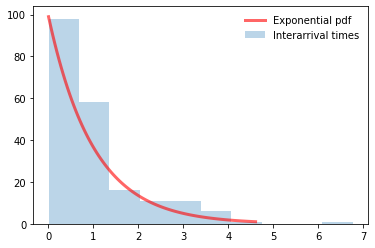

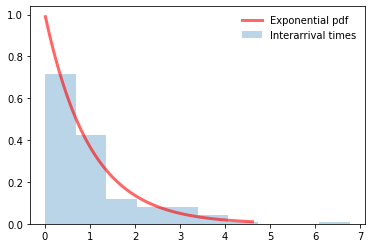

In [8]:
from scipy.stats import expon

fig, ax = plt.subplots(1, 1)
x = np.linspace(expon.ppf(0.01, scale = 1/P.lambd), expon.ppf(0.99, scale = 1/P.lambd), 100)
ax.plot(x, 100*expon.pdf(x), 'r-', lw = 3, alpha = 0.6, label = 'Exponential pdf')
ax.hist(df_interarrival.iloc[0], label = 'Interarrival times', density = False, histtype = 'stepfilled', alpha = 0.3)
ax.legend(loc='best', frameon=False)
plt.show()

# correct the figures!

fig, ax = plt.subplots(1, 1)
x = np.linspace(expon.ppf(0.01), expon.ppf(0.99), 100)  # adjust the lambda
ax.plot(x, expon.pdf(x, scale = 1/P.lambd), 'r-', lw = 3, alpha = 0.6, label = 'Exponential pdf')
ax.hist(df_interarrival.iloc[0], label = 'Interarrival times', density = True, histtype = 'stepfilled', alpha = 0.3)
ax.legend(loc='best', frameon=False)
plt.show()

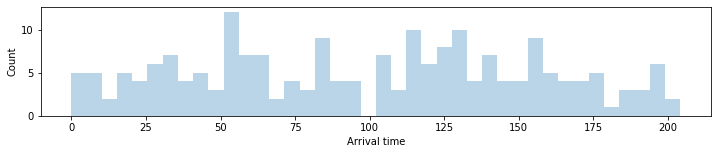

In [9]:
plt.figure(figsize=(12, 2))
plt.hist(df_arrival.iloc[0], density = False, histtype = 'stepfilled', bins = int(P.sim_time/5), alpha = 0.3)
plt.xlabel("Arrival time")
plt.ylabel("Count")
plt.show()

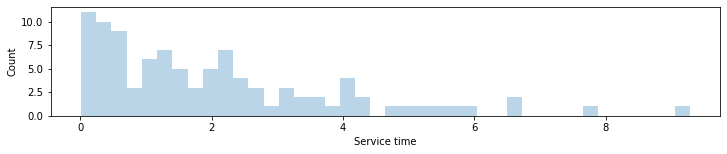

In [10]:
plt.figure(figsize=(12, 2))
plt.hist(df_service.iloc[0], density = False, histtype = 'stepfilled', bins = int(P.sim_time/5), alpha = 0.3)
plt.xlabel("Service time")
plt.ylabel("Count")
plt.show()

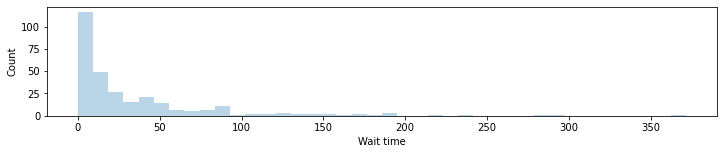

In [11]:
plt.figure(figsize=(12, 2))
plt.hist(df_wait.iloc[0], density = False, histtype = 'stepfilled', bins = int(P.sim_time/5), alpha = 0.3)
plt.xlabel("Wait time")
plt.ylabel("Count")
plt.show()

In [12]:
# Expected measurements in an M/M/1 queue
def expected(lambd, mu):
    rho = P.lambd / P.mu
    if rho < 1:
        L = rho / (1-rho)
        W = L / P.lambd         # by Little's Law
        Wq = rho / (P.mu - P.lambd)
        Lq = (rho**2) / (1-rho) # Average queue length
        Lqq = rho**2            # Average length of the nonempty queue
        P0 = 1 - rho            # Probability that there are no customers in the system
        return print("L:", L, "\nW:", W, "\nLq:", Lq, "\nWq:", Wq)
    else:
        return print("rho >= 1")
    
expected(P.lambd, P.mu)

L: 1.0 
W: 1.0 
Lq: 0.5 
Wq: 0.5
